In [1]:
from qiskit.circuit import *
import numpy as np
from qiskit_aer import StatevectorSimulator
from qiskit.result import marginal_counts
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.visualization.state_visualization import _bloch_multivector_data
from qiskit.quantum_info import random_statevector, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.add_control import add_control
from qiskit import transpile
import qiskit.quantum_info as qi
import functools


In [2]:
def inverse_qft(n: int, qc: QuantumCircuit):
    iqft = QuantumCircuit(qc.qubits[:n])
    # swap
    for i in range(n-1,-1,-1):
        iqft.h(i)
        for j in range(i):
            iqft.cp(np.pi/2**(i-j),j,i)

    for i in range(n//2):
        iqft.swap(i,n-1-i)
    iqft.barrier()
    iqft.name='iqft'
    qc.append(iqft.inverse(True),iqft.qubits)
    

In [3]:
import math
def c_amod15(a, power):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
                
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control(ctrl_state=1)

    return c_U

In [4]:
from typing import Callable

def shor(n_count:int, a:int, u: Callable[[int,int], QuantumCircuit]):    
# Create QuantumCircuit with n_count counting qubits
    # plus 4 qubits for U to act on
    qc = QuantumCircuit(n_count + 4, n_count)

    # Initialize counting qubits
    # in state |+>
    for q in range(n_count):
        qc.h(q)
        
    # And auxiliary register in state |1>
    qc.x(n_count)

    # Do controlled-U operations
    for q in range(n_count):
        qc.append(u(a, 2**q), [q] + [i+n_count for i in range(4)])

    # Do inverse-QFT
    inverse_qft(n_count,qc)
    
    # Measure circuit
    qc.measure(range(n_count), range(n_count))
    return qc


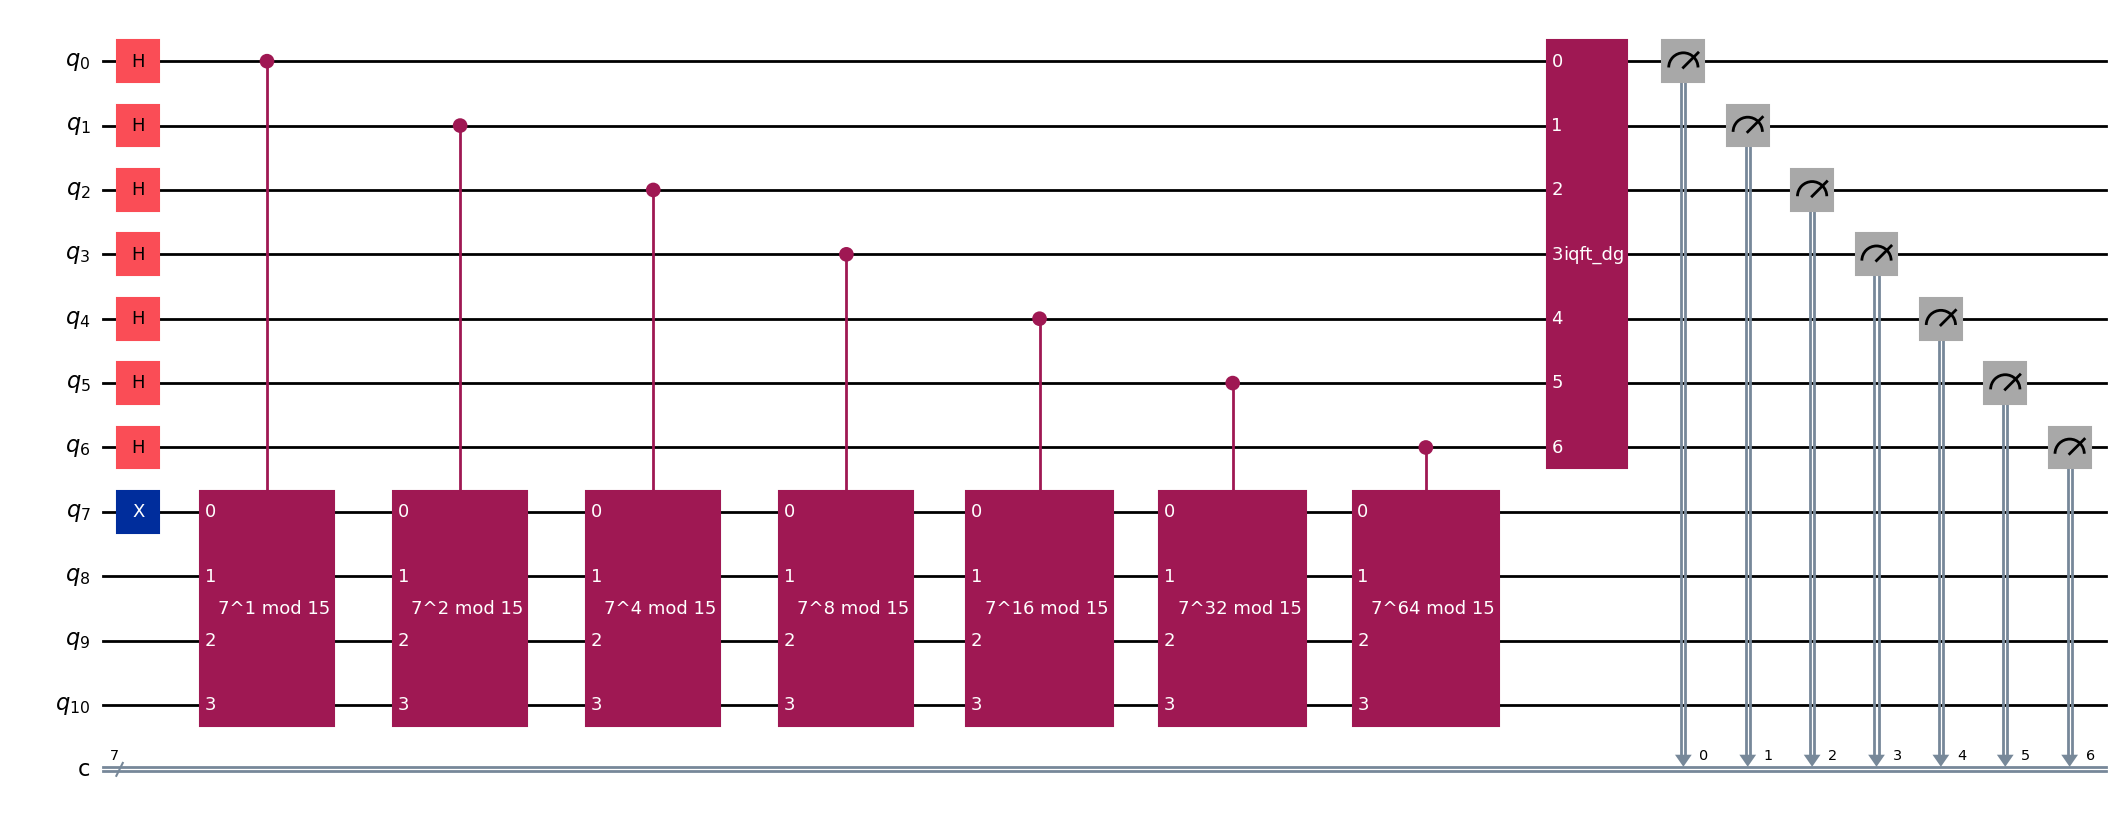

In [5]:
n=7
a=7
shor_qc = shor(n,a,c_amod15)
shor_qc.draw('mpl',fold=-1)

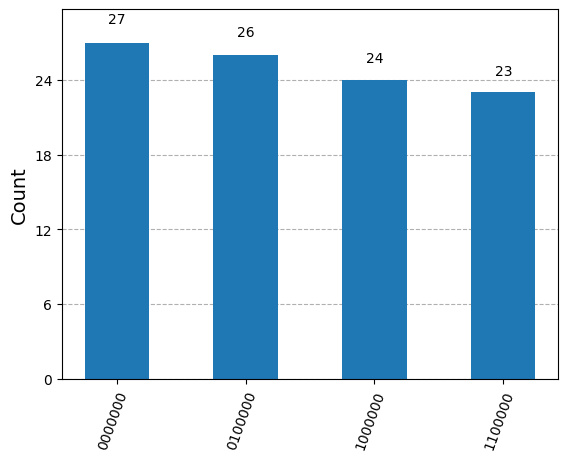

In [6]:
from qiskit.visualization import plot_histogram
backend = StatevectorSimulator()
job = backend.run(transpile(shor_qc,backend),memory=True,shots=100)
result =  job.result()
measured_phases = [int(key,2)/float(2**n) for key in result.get_counts().keys()]
plot_histogram(result.get_counts())

In [7]:
from fractions import Fraction
import pandas as pd
rows = []
maybes = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
    maybes.append(frac.denominator)
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.25      1/4            4
1   0.00      0/1            1
2   0.50      1/2            2
3   0.75      3/4            4


In [ ]:
r= np.lcm.reduce(maybes)
print(r)

4


In [9]:
for i in range(15):
    if np.gcd(i,15) == 1:
        print(i**4%15)

1
1
1
1
1
1
1
1


In [10]:
p=np.gcd(a**(r//2)+1, 15)
q=np.gcd(a**(r//2)-1, 15)
print(p,q)

5 3
